In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.layers import Input

In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dir = r'E:\brain-tumor-mri-dataset\Brain-NoBrain\train'
val_dir = r'E:\brain-tumor-mri-dataset\Brain-NoBrain\val'

train_data = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_data = data_gen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

checkpoint_callback = ModelCheckpoint(
    'brain_classifier_best.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint_callback, early_stop_callback]
)

model.save('brain_classifier_final_v2.h5')

Found 5871 images belonging to 2 classes.
Found 1468 images belonging to 2 classes.


d:\envs\BrainTumorAppEnvironment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


d:\envs\BrainTumorAppEnvironment\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8970 - loss: 0.9245
Epoch 1: val_loss improved from inf to 363.52313, saving model to brain_classifier_best.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 733s 4s/step - accuracy: 0.8972 - loss: 0.9212 - val_accuracy: 0.6975 - val_loss: 363.5231
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9682 - loss: 0.0716
Epoch 2: val_loss improved from 363.52313 to 0.92861, saving model to brain_classifier_best.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 658s 4s/step - accuracy: 0.9682 - loss: 0.0716 - val_accuracy: 0.3025 - val_loss: 0.9286
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9848 - loss: 0.0467
Epoch 3: val_loss improved from 0.92861 to 0.61792, saving model to brain_classifier_best.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.9848 - loss: 0.0467 - val_accuracy: 0.8787 - val_loss: 0.6179
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9885 - loss: 0.0344
Epoch 4: val_loss improved 

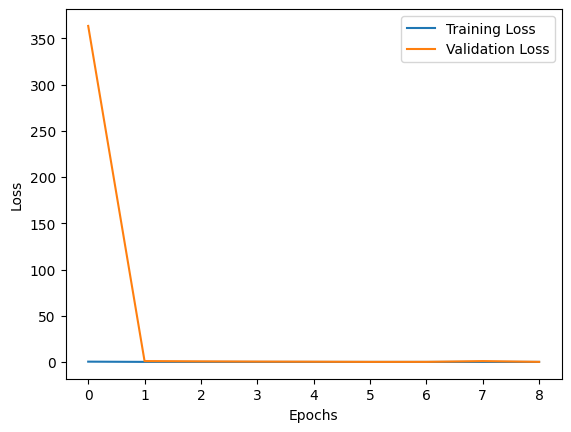

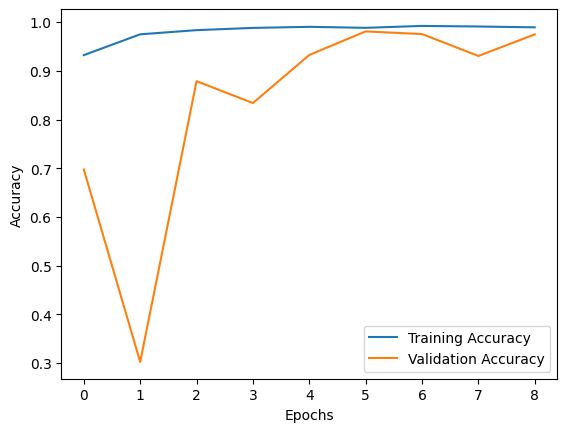

In [5]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
from tensorflow.keras.models import load_model
import numpy as np

In [12]:
# Load the trained model
model_path = r'E:\brain_classifier_final_v2.h5'
model = load_model(model_path)

test_dir = r'E:\brain-tumor-mri-dataset\Brain-NoBrain\test'  

test_data_gen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True  
)


test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Found 1836 images belonging to 2 classes.


d:\envs\BrainTumorAppEnvironment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 756ms/step - accuracy: 0.9722 - loss: 0.0876
Test Accuracy: 97.60%
Test Loss: 0.0799


58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 755ms/step


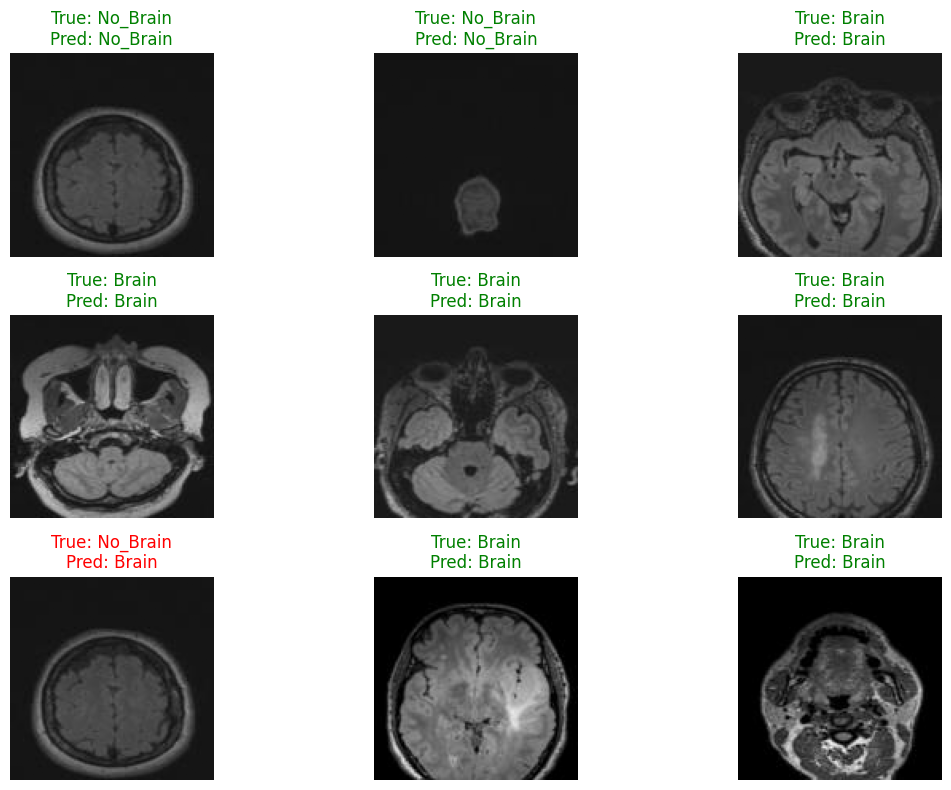

In [23]:

predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int)  

class_labels = list(test_data.class_indices.keys())

def display_predictions(test_data, predicted_classes):
    images, true_labels = next(test_data)  
    true_classes = true_labels.astype(int)
    
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predicted_classes[i][0]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


display_predictions(test_data, predicted_classes)